In [261]:
import numpy as np
from statsmodels.tsa.arima_process import ArmaProcess
import os
import pandas as pd
from functools import reduce
from statsmodels.tsa.stattools import adfuller, kpss
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

def adf_test(timeseries, regression = "c"):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC", regression = regression)
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)


# Procesos ARMA

## Moving Average (Media Móvil)

Un proceso de medias móviles es aquel que tiene una dependencia lineal con los términos de error del presente y pasados. Se denota $M(q)$:

$$ y_t = \mu + \epsilon_t + \theta_1\epsilon_{t-1} +\theta_2\epsilon_{t-2}+ \dots + \theta_q\epsilon_{t-q} $$

### Ejemplo

$$ y_t = \epsilon_t + 0.5\epsilon_{t-1} + 0.7\epsilon_{t-2}$$


In [94]:
ma2 = np.array([1, 0.5, 0.7])
ar2 = np.array([1, 0, 0])
proceso_ma2 = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)


1. Gráfico

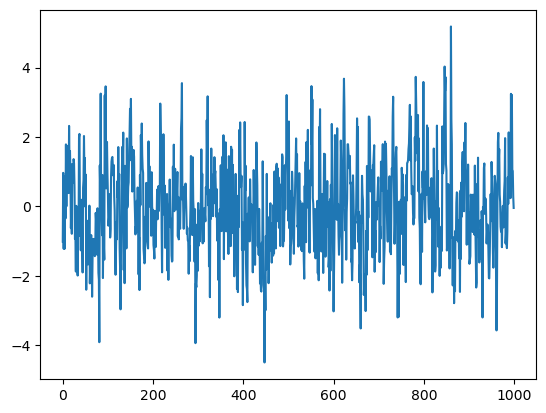

In [97]:
plt.plot(proceso_ma2)

2. Estacionariedad

In [100]:
adf_test(proceso_ma2)

Results of Dickey-Fuller Test:
Test Statistic                -9.237922e+00
p-value                        1.611592e-15
#Lags Used                     9.000000e+00
Number of Observations Used    9.900000e+02
Critical Value (1%)           -3.436973e+00
Critical Value (5%)           -2.864464e+00
Critical Value (10%)          -2.568327e+00
dtype: float64


3. ACF

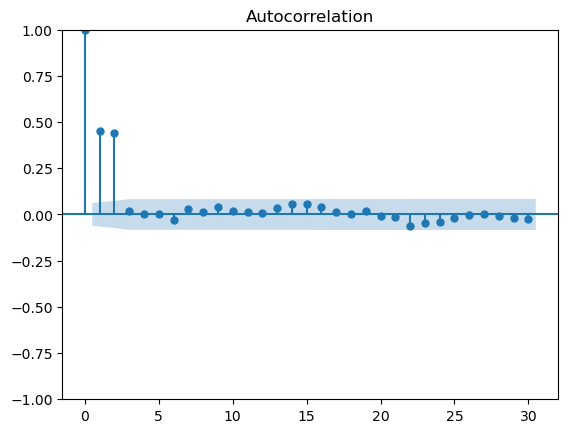

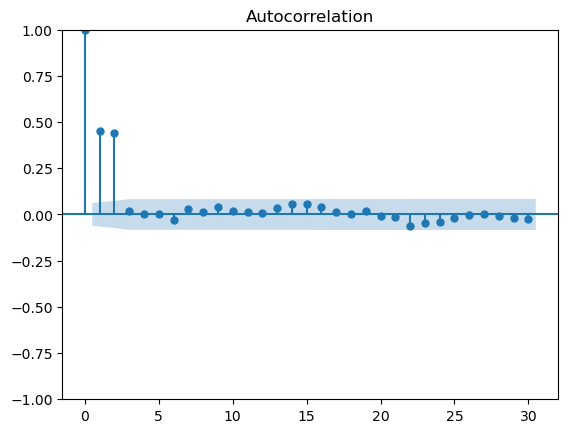

In [105]:
plot_acf(proceso_ma2)
plt.show()

4. Predicción

In [152]:
train = proceso_ma2[:900]
test = proceso_ma2[900:]
modeloMA = sm.tsa.SARIMAX(train, order = (0,0,2))
fit = modeloMA.fit()
prediccion = fit.predict(0,999)

In [154]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  900
Model:               SARIMAX(0, 0, 2)   Log Likelihood               -1300.919
Date:                Thu, 25 Jul 2024   AIC                           2607.838
Time:                        12:30:03   BIC                           2622.245
Sample:                             0   HQIC                          2613.341
                                - 900                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4556      0.023     19.589      0.000       0.410       0.501
ma.L2          0.7022      0.024     28.878      0.000       0.655       0.750
sigma2         1.0528      0.048     22.034      0.000       0.959       1.146
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 5.98
Prob(Q):                              0.68   Prob(JB):                         0.05
Heteroskedasticity (H):               1.19   Skew:                             0.14
Prob(H) (two-sided):                  0.13   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

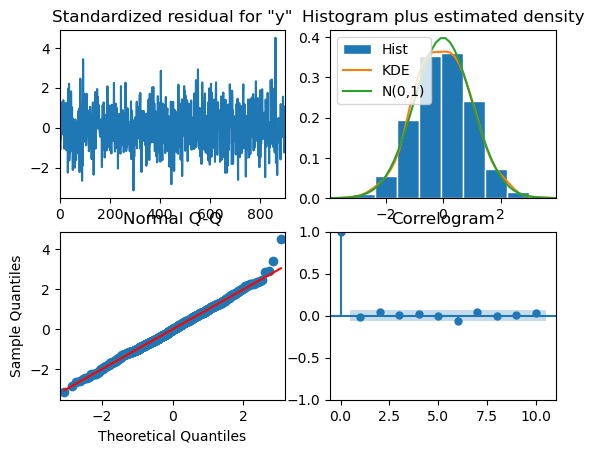

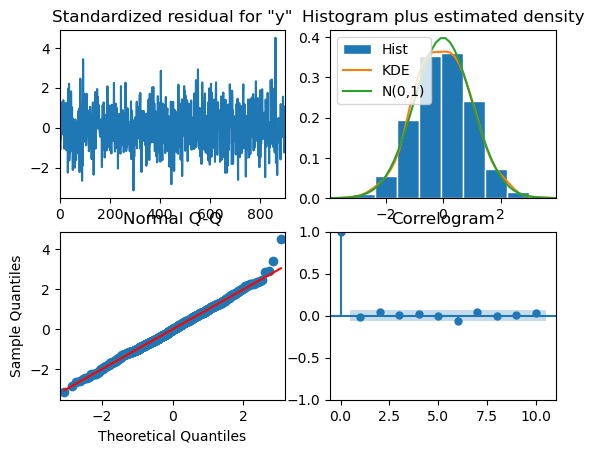

In [156]:
fit.plot_diagnostics()
plt.show()

<Axes: >

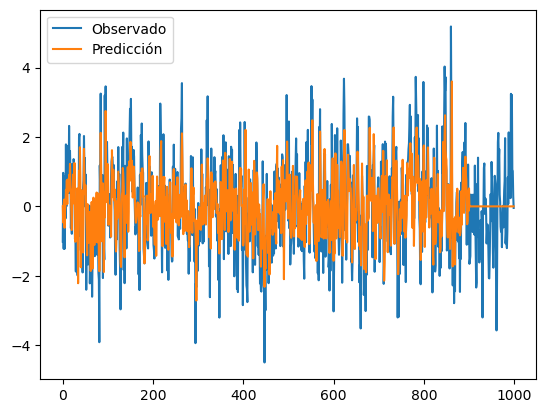

In [158]:
pd.DataFrame({"Observado": proceso_ma2, "Predicción": prediccion}).plot()

La predicción de un modelo $MA(q)$ solo es posible $q$ pasos hacia adelante, porque no hay términos de error para estimar más allá de $q$ pasos. En ese caso, solo dará como resultado la media de la serie. 

In [169]:
def rolling_forecast(df, train, test, window):
    train_len = len(train)
    total_len = train_len + len(test)
    pred_MA = []
    for i in range(len(train), total_len, window):
        model = SARIMAX(df[:i], order=(0,0,2))
        res = model.fit(disp=False)
        predictions = res.get_prediction(0, i + window - 1)
        oos_pred = predictions.predicted_mean.iloc[-window:]
        pred_MA.extend(oos_pred)
    return pred_MA

In [171]:
prediccion = rolling_forecast(pd.Series(proceso_ma2), train, test, 2)

<Axes: >

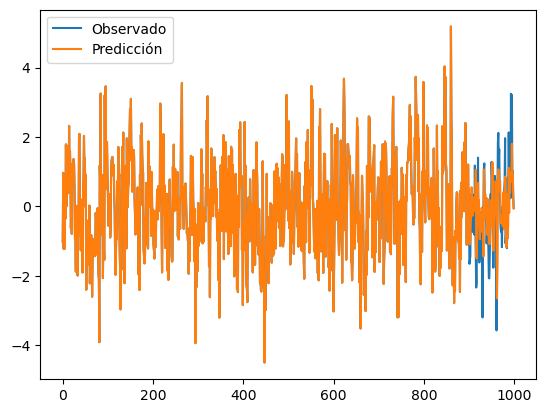

In [185]:
pd.DataFrame({"Observado": proceso_ma2, "Predicción": np.concatenate([train, prediccion])}).plot()

## Proceso autorregresivo (AR)

Un proceso autorregresivo es una regresión de la variable consigo misma. El presente tiene una dependencia lineal con el pasado. Se denota como $AR(p)$:

$$ y_t = C + \phi_1 y_1 + \phi_2 y_2 + \dots + \phi_p y_p + \epsilon_t$$

### Ejemplos:

$$AR1a : y_t -0.7y_{t-1} = \epsilon_t \Rightarrow y_t = 0.7y_{t-1}  + \epsilon_t $$
$$AR1b : y_t = -0.7y_{t-1}  + \epsilon_t $$
$$AR3 : y_t = 0.5y_{t-1} - 0.4y_{t-2} +0.3y_{t-3}    + \epsilon_t $$

In [277]:
ma1 = np.array([1, 0])
ar1 = np.array([1, -0.7])
proceso_ar1a = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

ma1 = np.array([1, 0])
ar1 = np.array([1, 0.7])
proceso_ar1b = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

ma3 = np.array([1, 0, 0, 0])
ar3 = np.array([1, -0.5, 0.4, -0.3])
proceso_ar3 = ArmaProcess(-ar3, ma3).generate_sample(nsample=1000)

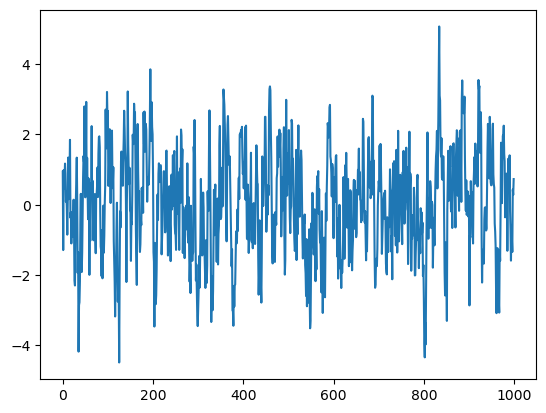

In [279]:
plt.plot(proceso_ar1a)

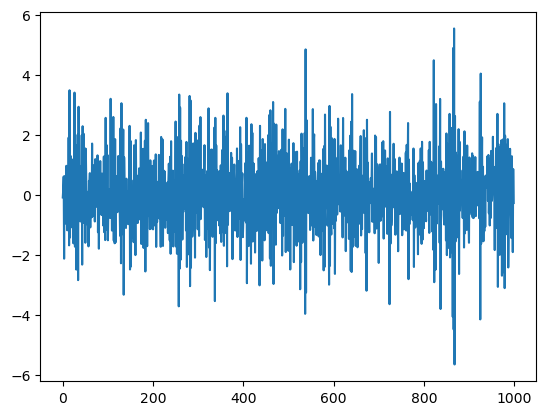

In [280]:
plt.plot(proceso_ar1b)

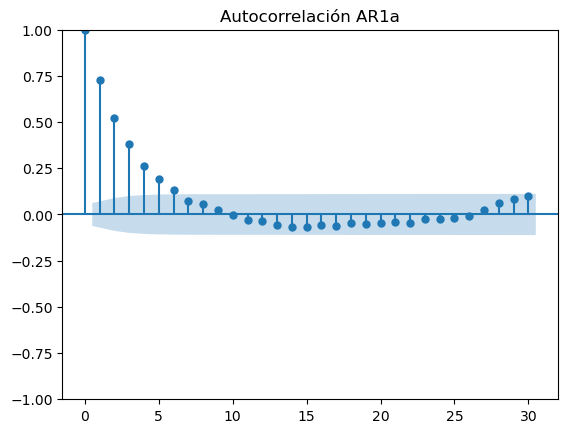

In [282]:
plot_acf(proceso_ar1a, title = "Autocorrelación AR1a")
plt.show()

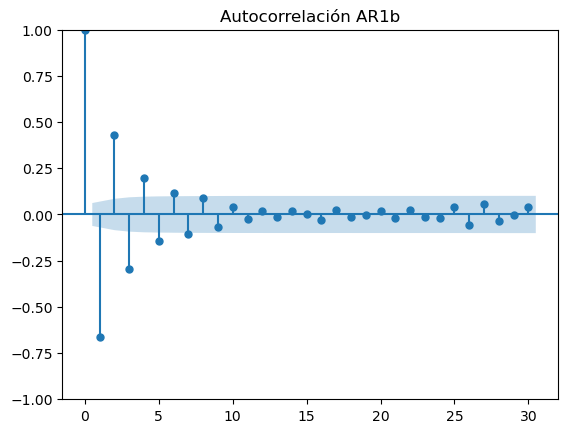

In [257]:
plot_acf(proceso_ar1b, title = "Autocorrelación AR1b")
plt.show()

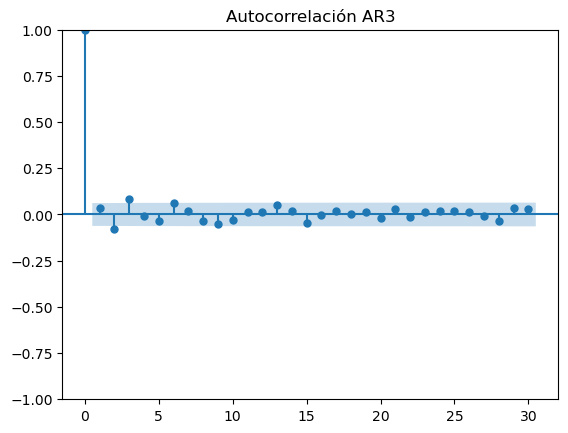

In [259]:
plot_acf(proceso_ar3, title = "Autocorrelación AR3")
plt.show()

### Autocorrelación parcial

Mide la correlación entre los valores rezagados en una serie de tiempo cuando removemos la influencia de los otros rezagos en medio. Queremos aislar el efecto de un rezago en particular.

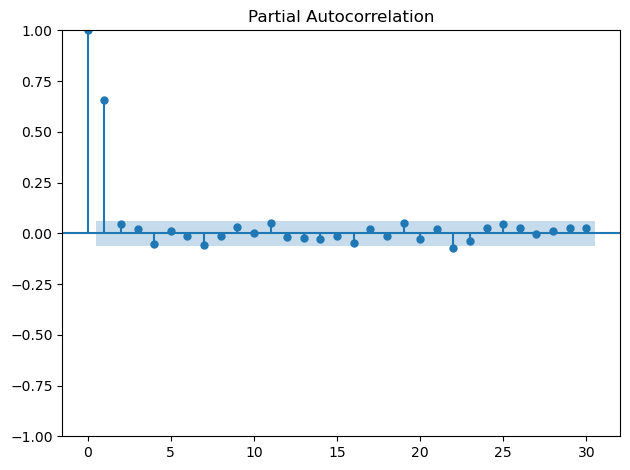

In [264]:
plot_pacf(proceso_ar1a);
plt.tight_layout()

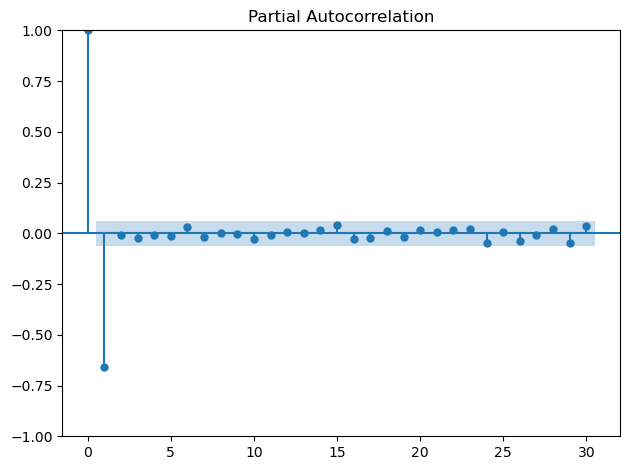

In [268]:
plot_pacf(proceso_ar1b);
plt.tight_layout()

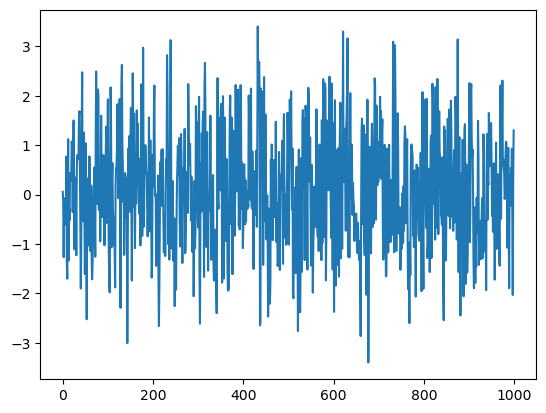

In [287]:
plt.plot(proceso_ar3);

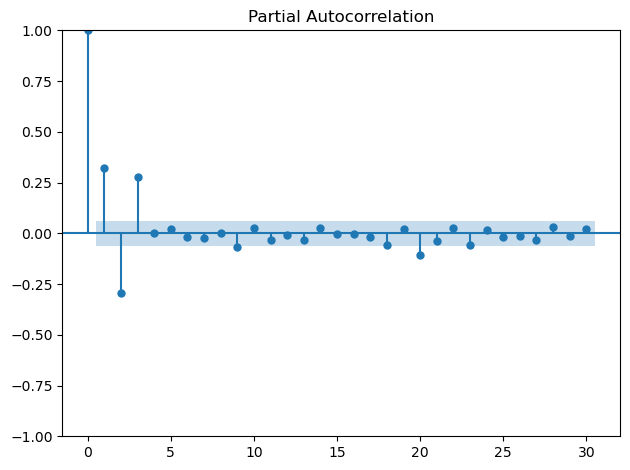

In [289]:
plot_pacf(proceso_ar3);
plt.tight_layout()

<Axes: >

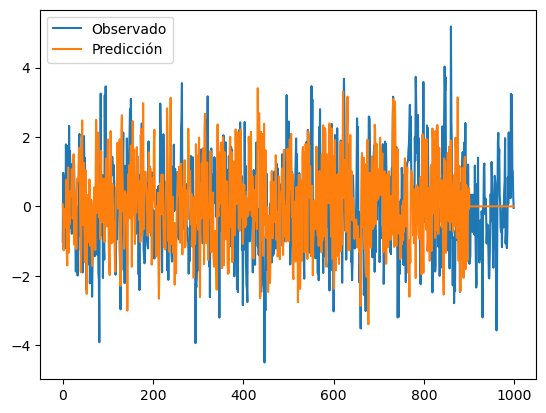

In [295]:
train = proceso_ar3[:900]
test = proceso_ar3[900:]
modeloAR = sm.tsa.SARIMAX(train, order = (3,0,0))
fit = modeloMA.fit()
prediccion = fit.forecast(100)
pd.DataFrame({"Observado": proceso_ma2, "Predicción": np.concatenate([train, prediccion])}).plot()

In [ ]:
prediccion = rolling_forecast(pd.Series(proceso_ar3), train, test, 2)